In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# HW2

#### **Задание**: Реализовать взвешенное голосование между градиентным бустингом с логистической функцией потерь, AdaBoost и SVM. Реализацию SVM и AdaBoost взять из sklearn.

In [2]:
import pandas as pd
import numpy as np
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt

In [53]:
df = pd.read_csv("./spam.train.txt", delim_whitespace=True, header=None)
x_data = df.ix[:, 1:].as_matrix(); y_data = df.ix[:, 0].as_matrix()
y_data[y_data == 0] = -1
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                       test_size=0.25, random_state=288)


# CART Implementation 

In [54]:
from src.CART import CART

In [55]:
%timeit CART().fit(x_train, y_train)

1 loops, best of 3: 4.87 s per loop


In [56]:
def run_cv(X, y):
    kf = KFold(len(y), n_folds=3)

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cart = CART()
        cart.fit(X_train, y_train)
        y_pred = cart.predict(X_test)
        print "Cart :", mean_squared_error(y_test, y_pred)
        
        dtr = DecisionTreeRegressor(max_depth=4)
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
        print "SKlearn:", mean_squared_error(y_test, y_pred)
        
run_cv(x_train, y_train)

Cart : 0.339277251539
SKlearn: 0.358113411309
Cart : 0.332214001595
SKlearn: 0.358306601563
Cart : 0.300975971041
SKlearn: 0.359058183769


# GBoost Implementation

In [57]:
from src.GBoost import GBoost

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
gboost = GBoost(10)
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9


In [60]:
pred = gboost.predict(x_test, 7)
mean_squared_error(y_test, pred)

0.21420518602029312

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=5)
gbc.fit(x_train, y_train)
pred = gbc.predict(x_test)
mean_squared_error(y_test, pred)

0.22322435174746336

# Performance Graph

In [17]:
from src.benchmark import draw_graph_hw1

In [18]:
# Tooo long
# gboost_scores, sklearn_scores = draw_graph_hw1(x_train, x_test, y_train, y_test, 300)
# np.savez("scores.dat", gboost_scores=gboost_scores, sklearn_scores=sklearn_scores)

In [19]:
scores = np.load('scores.dat.npz')

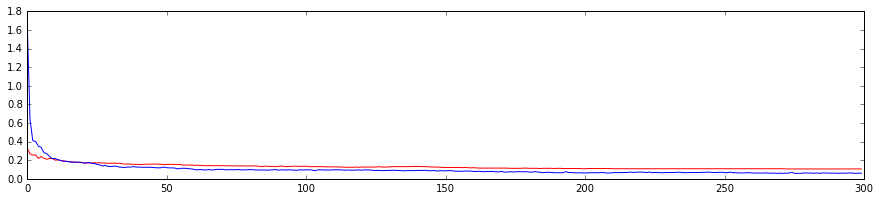

In [23]:
plt.figure(figsize=(15, 3))

plt.plot(range(len(scores["gboost_scores"])), scores["gboost_scores"], c="r")
plt.plot(range(len(scores["sklearn_scores"])), scores["sklearn_scores"], c="b")

# Weighted Majority

![http://www.kddresearch.org/Courses/Fall-2003/CIS732/Lectures/Lecture-20-20021107.pdf](http://take.ms/HrNMf)

In [ ]:
def weighted_majority(predictors, x_train, y_train, betta = 0.65):
    n_samples = x_train.shape[0]
    m_predictors = len(predictors)
    w = np.ones(m_predictors)
    
    prediction = np.zeros((n_samples, m_predictors))
    
    for n in range(n_samples):
        qneg = 0; qpos = 0
        
        for m in range(m_predictors):
            pred = predictors[m].predict(x_train[n,:])

            qneg += w[m] if pred == -1 else 0
            qpos += w[m] if pred == 1 else 0
            
            if qneg > qpos:
                prediction[n, m] = -1
            elif qneg == qpos:
                prediction[n, m] = 1 if np.random.randint(0,2) else -1
            else 
                prediction[n, m] = 1
            
            if prediction[n, m] != y_train[n]:
                w[m] *= betta
    
    print w
            
            
        

### GBoost

In [ ]:
gboost = GBoost(100)
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

### AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_Boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ada_Boost_clf.fit(x_train, y_train)
y_pred = ada_Boost_clf.predict(x_test)
mean_squared_error(y_test, y_pred)

0.20067643742953778

### SVM

In [32]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
mean_squared_error(y_test, y_pred)

0.21420518602029312